<a href="https://colab.research.google.com/github/ritikgoyal1701/Drowsiness-Detector/blob/main/Drowsiness_Dataset_Preprocessing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Downloading the dataset

In [ ]:
!wget "http://vlm1.uta.edu/~athitsos/projects/drowsiness/Fold1_part1.zip"

--2021-06-15 04:07:16--  http://vlm1.uta.edu/~athitsos/projects/drowsiness/Fold1_part1.zip
Resolving vlm1.uta.edu (vlm1.uta.edu)... 129.107.118.39
Connecting to vlm1.uta.edu (vlm1.uta.edu)|129.107.118.39|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 12880106338 (12G) [application/zip]
Saving to: ‘Fold1_part1.zip’

Fold1_part1.zip     100%[===================>]  12.00G  18.2MB/s    in 10m 29s 

2021-06-15 04:17:45 (19.5 MB/s) - ‘Fold1_part1.zip’ saved [12880106338/12880106338]



Unzipping the dataset

In [ ]:
!unzip "*.zip"

Archive:  Fold1_part1.zip
   creating: Fold1_part1/
   creating: Fold1_part1/06/
  inflating: Fold1_part1/06/5.mp4    
  inflating: Fold1_part1/06/10.mp4   
  inflating: Fold1_part1/06/0.mp4    
   creating: Fold1_part1/03/
  inflating: Fold1_part1/03/10.mov   
  inflating: Fold1_part1/03/5.mov    
  inflating: Fold1_part1/03/0.MOV    
   creating: Fold1_part1/05/
  inflating: Fold1_part1/05/5.MOV    
  inflating: Fold1_part1/05/10.MOV   
  inflating: Fold1_part1/05/0.MOV    
   creating: Fold1_part1/04/
  inflating: Fold1_part1/04/5.mp4    
  inflating: Fold1_part1/04/0.mp4    
  inflating: Fold1_part1/04/10.mp4   
   creating: Fold1_part1/01/
  inflating: Fold1_part1/01/10.MOV   
  inflating: Fold1_part1/01/5.mov    
  inflating: Fold1_part1/01/0.mov    
   creating: Fold1_part1/02/
  inflating: Fold1_part1/02/0.mov    
  inflating: Fold1_part1/02/5.MOV    
  inflating: Fold1_part1/02/10.MOV   


Removing the zip file as the size of dataset is too big, so to work smoothly delete a zip file after unzipping it.


In [ ]:
!rm "Fold1_part1.zip"

Now, detecting the face and getting the coordinates of all landmarks of faces.

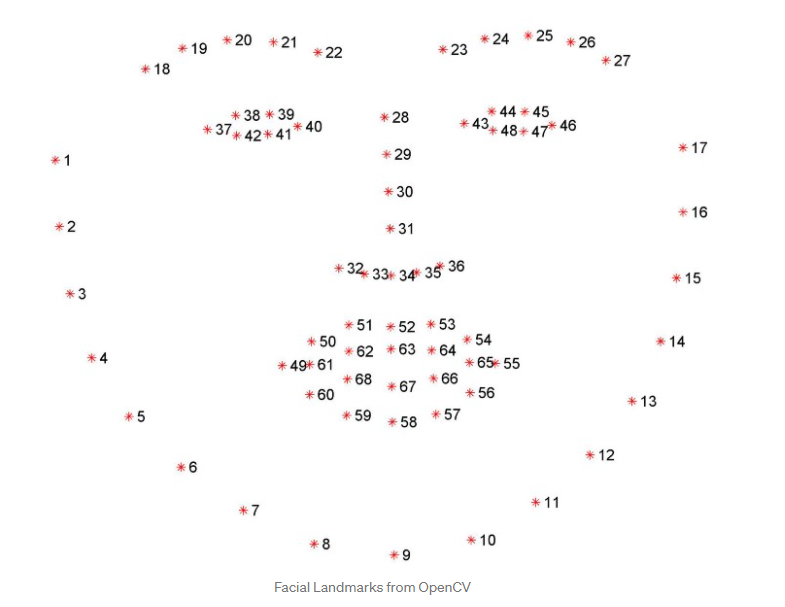

In [ ]:
!wget "http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2"
!bzip2 -d shape_predictor_68_face_landmarks.dat.bz2

--2021-06-15 04:21:56--  http://dlib.net/files/shape_predictor_68_face_landmarks.dat.bz2
Resolving dlib.net (dlib.net)... 107.180.26.78
Connecting to dlib.net (dlib.net)|107.180.26.78|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 64040097 (61M)
Saving to: ‘shape_predictor_68_face_landmarks.dat.bz2’

shape_predictor_68_ 100%[===================>]  61.07M  74.3MB/s    in 0.8s    

2021-06-15 04:21:57 (74.3 MB/s) - ‘shape_predictor_68_face_landmarks.dat.bz2’ saved [64040097/64040097]



In [ ]:
import dlib
import cv2
import os
import numpy as np
import imutils
from imutils import face_utils
from PIL import Image
import matplotlib.pyplot as plt
face_detector = dlib.get_frontal_face_detector()   
landmark_detector = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat")
def detector(frame):
  #image=frame.rotate(270,expand=True)
  #frame=np.rot90(frame, k=3, axes=(0, 1))
  image=imutils.resize(frame, width=400)#cv2.imread(frame)
  gray_image=cv2.cvtColor(image,cv2.COLOR_BGR2GRAY)
  #cv2_imshow(gray_image)
  rects = face_detector(gray_image,0)
  for rect in rects:
    shape=landmark_detector(gray_image,rect)
    shape = face_utils.shape_to_np(shape)
    return shape
  return [1]

Distance between given 2 coordinates

In [ ]:
def distance(c1,c2):
  k1=(c1[0]-c2[0])**2
  k2=(c1[1]-c2[1])**2
  dis=(k1+k2)**(0.5)
  return dis

Calculating Features

In [ ]:
import math
def Eye_Aspect_Ratio(land):
  k1=distance(land[37],land[41])
  k2=distance(land[38],land[40])
  k3=distance(land[36],land[39])
  ear=(k1+k2)/(2*k3)
  return ear

def Mouth_Aspect_Ratio(land):
  k1=distance(land[51],land[57])
  k2=distance(land[48],land[54])
  mar=k1/k2
  return mar

def Pupil_Circularity(land):
  k1=distance(land[37],land[40])/2
  Area=math.pi*(k1**2)
  Perimeter=distance(land[36],land[37])+distance(land[37],land[38])+distance(land[38],land[39])+distance(land[39],land[40])+distance(land[40],land[41])+distance(land[41],land[36])
  puc=4*math.pi*Area/(Perimeter**2)
  return puc

def Mouth_Eye(land):
  k1=Eye_Aspect_Ratio(land)
  k2=Mouth_Aspect_Ratio(land)
  moe=k2/k1
  return moe


In [ ]:
def Feature_Extraction(image):
  land=detector(image)
  #try:
  if len(land)==68:
    EAR=Eye_Aspect_Ratio(land)
    MAR=Mouth_Aspect_Ratio(land)
    PUC=Pupil_Circularity(land)
    MOE=Mouth_Eye(land)
    return [EAR,MAR,PUC,MOE]
  return [1]

Getting frames from video

In [ ]:
from google.colab.patches import cv2_imshow
def Feature_Video(path,k):
  features=[]
  video=cv2.VideoCapture(path)
  success,image=video.read()
  i=0
  while success:
    #cv2_imshow(image)
    extract=Feature_Extraction(image)
    #extract=detector(image)
    if len(extract)>1:
      features.append(extract)
      i=1+i
      if i>k:
        break
    success,image=video.read()
  return features

Normalizing the calculated data

In [ ]:
def Normalizer(Features,Mean,Std):
  for Feature in Features:
    for i in range(4):
      Feature[i]=(Feature[i]-Mean[i])/Std[i]

Creating Data for Normalization

In [ ]:
import pandas as pd
def Normalize_Help_Data(path):
  Normalize=Feature_Video(path,10)
  Data=pd.DataFrame(Normalize,columns=["EAR","MAR","PUC","MOE"])
  Mean=Data.mean()
  Std=Data.std()
  return Mean,Std

Creating our Dataset

> Here we are doing for each video manually instead of using loop or direct way instead of manual, reasons are:-


1.   We don't know the orientation of video whether it's in landscape or potrait mode, So we have to check and convert it to portrait.
2.   The extension of the video clip are not in regular format.


Person 1

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/01/0.mov")

In [ ]:
Mean

EAR    0.300811
MAR    0.383910
PUC    0.462156
MOE    1.274403
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/01/0.mov",10000)

In [ ]:
Normalizer(Feature_Alert,Mean,Std)

In [ ]:
Feature_Alert[:5]

[[-0.6368214417580648,
  0.3415780001690722,
  -1.47311700376144,
  0.552137096935536],
 [0.40215550573116166,
  0.3415780001690722,
  -0.09635900987705742,
  0.22280665201243977],
 [-0.28722031804345793,
  0.2628845303674754,
  0.12690856959356556,
  0.3553320069840687],
 [-0.28722031804345793,
  0.620248524203123,
  0.31004718226085914,
  0.717857894638155],
 [0.8610562977329016,
  0.5300391611105716,
  2.2109095552781057,
  0.268407880570613]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])

Exporting the Alert dataframe to csv file and then saving it to Drive

In [ ]:
Alert_DataSet.to_csv("Alert.csv")

In [ ]:
from google.colab import drive
drive.mount('Drive')

Drive already mounted at Drive; to attempt to forcibly remount, call drive.mount("Drive", force_remount=True).


In [ ]:
!mv "Alert.csv" "Drive/MyDrive/Project/Drowsiness/Dataset"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/01/10.MOV",10000)

In [ ]:
Normalizer(Feature_Drowsy,Mean,Std)

In [ ]:
Feature_Drowsy[:5]

[[-1.6952191191229284,
  -0.4786951500385736,
  -2.5421264290749197,
  0.012933591135216319],
 [-1.1172499159639724,
  -0.08876133083853154,
  -0.3741875573334138,
  0.25654760378946906],
 [-1.6536703990323631,
  -0.3250833675563921,
  -0.6278309353351076,
  0.17446671532165156],
 [-1.6536703990323631,
  -0.3250833675563921,
  -0.5147416081116621,
  0.17446671532165156],
 [-1.6536703990323631,
  -0.40558474686084917,
  -0.5147416081116621,
  0.08269043429796559]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
Drowsy_DataSet.to_csv("Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")

Person 2

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/02/0.mov")

In [ ]:
Mean

EAR    0.335792
MAR    0.435748
PUC    0.458516
MOE    1.303411
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/02/0.mov",10000)

In [ ]:
Normalizer(Feature_Alert,Mean,Std)

In [ ]:
Feature_Alert[:5]

[[-1.094737103354241,
  -0.30967707500213243,
  -0.10990957503768581,
  0.7762097789980167],
 [-1.094737103354241,
  -0.30967707500213243,
  -0.10990957503768581,
  0.7762097789980167],
 [-0.11554901058393305,
  1.741359558717415,
  1.2922542937537278,
  0.6011544107621595],
 [0.8636390821863775,
  -1.2256416671380423,
  1.406005937878083,
  -1.0828145195585],
 [0.9788335957836046,
  -0.3897052885528943,
  -0.5660032384539946,
  -0.9092837392175818]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
df=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv")

In [ ]:
pd.concat([Alert_DataSet,df]).to_csv("Alert.csv")

In [ ]:
pd.read_csv("Alert.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE,Unnamed: 0.1
0,0,-1.094737,-0.309677,-0.109910,0.776210,NaN
1,1,-1.094737,-0.309677,-0.109910,0.776210,NaN
2,2,-0.115549,1.741360,1.292254,0.601154,NaN
3,3,0.863639,-1.225642,1.406006,-1.082815,NaN
4,4,0.978834,-0.389705,-0.566003,-0.909284,NaN
...,...,...,...,...,...,...
19997,9996,1.101467,0.228743,0.921352,-0.073856,9996.0
19998,9997,0.290266,0.069983,-1.529633,-0.007520,9997.0
19999,9998,1.901880,0.275737,2.221742,-0.226629,9998.0
20000,9999,1.101467,-0.078860,-0.313887,-0.354479,9999.0


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"
!mv "Alert.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/02/10.MOV",10000)

In [ ]:
Normalizer(Feature_Drowsy,Mean,Std)

In [ ]:
Feature_Drowsy[:5]

[[-2.016281152404749,
  -2.397064596403657,
  -1.4248047489933382,
  0.9058074731410855],
 [-0.06822196648950485,
  -1.216270552587238,
  2.1384458111158855,
  -0.393711751166352],
 [-1.107470370933307,
  -3.2145373959688723,
  -0.10990957503768581,
  -0.21647093362941444],
 [-2.085809579198347,
  -0.36340711243225743,
  -1.3104284034145106,
  1.7279765090220374],
 [-2.073925196124549,
  -3.2145373959688723,
  -1.6108688227562595,
  0.6602585699366192]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
Drowsy_DataSet

,EAR,MAR,PUC,MOE
0,-2.016281,-2.397065,-1.424805,0.905807
1,-0.068222,-1.216271,2.138446,-0.393712
2,-1.107470,-3.214537,-0.109910,-0.216471
3,-2.085810,-0.363407,-1.310428,1.727977
4,-2.073925,-3.214537,-1.610869,0.660259
...,...,...,...,...
9996,-1.491399,-6.420626,-2.392345,-1.020641
9997,-1.046561,-5.893849,0.410360,-1.190395
9998,-1.046561,-7.906120,-0.108792,-1.883246
9999,-2.512196,-7.852494,-2.062036,-0.673352


In [ ]:
Drowsy1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")

In [ ]:
Drowsy1.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
pd.concat([Drowsy1,Drowsy_DataSet]).to_csv("Drowsy.csv")

In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"
!mv "Drowsy.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

In [ ]:
pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-1.695219,-0.478695,-2.542126,0.012934
1,1,-1.117250,-0.088761,-0.374188,0.256548
2,2,-1.653670,-0.325083,-0.627831,0.174467
3,3,-1.653670,-0.325083,-0.514742,0.174467
4,4,-1.653670,-0.405585,-0.514742,0.082690
...,...,...,...,...,...
19997,9996,-1.491399,-6.420626,-2.392345,-1.020641
19998,9997,-1.046561,-5.893849,0.410360,-1.190395
19999,9998,-1.046561,-7.906120,-0.108792,-1.883246
20000,9999,-2.512196,-7.852494,-2.062036,-0.673352


Person 3

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/03/0.MOV")

In [ ]:
Mean

EAR    0.335471
MAR    0.243553
PUC    0.466773
MOE    0.726369
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/03/0.MOV",10000)

In [ ]:
Normalizer(Feature_Alert,Mean,Std)

In [ ]:
Feature_Alert[:5]

[[0.7273130957123243,
  -0.4333525134570639,
  -1.326813291878501,
  -0.662582350015529],
 [-0.3782064581676549,
  -0.5027326285701436,
  -1.022560751716497,
  -0.42445990131560285],
 [-1.5530294657926302,
  -0.8269541213187177,
  -0.5690609107198085,
  -0.42668440838349386],
 [0.6656600249867306,
  -0.932424522370548,
  1.109137323782017,
  -1.1556988107673754],
 [0.9943015730372893,
  0.7435198730595702,
  1.284009615723955,
  0.4494374303689014]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
Alert1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv")

In [ ]:
Alert1

,Unnamed: 0,EAR,MAR,PUC,MOE,Unnamed: 0.1
0,0,-1.094737,-0.309677,-0.109910,0.776210,NaN
1,1,-1.094737,-0.309677,-0.109910,0.776210,NaN
2,2,-0.115549,1.741360,1.292254,0.601154,NaN
3,3,0.863639,-1.225642,1.406006,-1.082815,NaN
4,4,0.978834,-0.389705,-0.566003,-0.909284,NaN
...,...,...,...,...,...,...
19997,9996,1.101467,0.228743,0.921352,-0.073856,9996.0
19998,9997,0.290266,0.069983,-1.529633,-0.007520,9997.0
19999,9998,1.901880,0.275737,2.221742,-0.226629,9998.0
20000,9999,1.101467,-0.078860,-0.313887,-0.354479,9999.0


In [ ]:
Alert1.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
Alert1

,EAR,MAR,PUC,MOE,Unnamed: 0.1
0,-1.094737,-0.309677,-0.109910,0.776210,NaN
1,-1.094737,-0.309677,-0.109910,0.776210,NaN
2,-0.115549,1.741360,1.292254,0.601154,NaN
3,0.863639,-1.225642,1.406006,-1.082815,NaN
4,0.978834,-0.389705,-0.566003,-0.909284,NaN
...,...,...,...,...,...
19997,1.101467,0.228743,0.921352,-0.073856,9996.0
19998,0.290266,0.069983,-1.529633,-0.007520,9997.0
19999,1.901880,0.275737,2.221742,-0.226629,9998.0
20000,1.101467,-0.078860,-0.313887,-0.354479,9999.0


In [ ]:
Alert1.drop("Unnamed: 0.1",axis=1,inplace=True)

In [ ]:
Alert1

,EAR,MAR,PUC,MOE
0,-1.094737,-0.309677,-0.109910,0.776210
1,-1.094737,-0.309677,-0.109910,0.776210
2,-0.115549,1.741360,1.292254,0.601154
3,0.863639,-1.225642,1.406006,-1.082815
4,0.978834,-0.389705,-0.566003,-0.909284
...,...,...,...,...
19997,1.101467,0.228743,0.921352,-0.073856
19998,0.290266,0.069983,-1.529633,-0.007520
19999,1.901880,0.275737,2.221742,-0.226629
20000,1.101467,-0.078860,-0.313887,-0.354479


In [ ]:
pd.concat([Alert_DataSet,Alert1]).to_csv("Alert.csv")

In [ ]:
pd.read_csv("Alert.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,0.727313,-0.433353,-1.326813,-0.662582
1,1,-0.378206,-0.502733,-1.022561,-0.424460
2,2,-1.553029,-0.826954,-0.569061,-0.426684
3,3,0.665660,-0.932425,1.109137,-1.155699
4,4,0.994302,0.743520,1.284010,0.449437
...,...,...,...,...,...
29998,19997,1.101467,0.228743,0.921352,-0.073856
29999,19998,0.290266,0.069983,-1.529633,-0.007520
30000,19999,1.901880,0.275737,2.221742,-0.226629
30001,20000,1.101467,-0.078860,-0.313887,-0.354479


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
!mv "Alert.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/03/10.mov",10000)

In [ ]:
Normalizer(Feature_Drowsy,Mean,Std)

In [ ]:
Feature_Drowsy[:5]

[[-11.240847186909528,
  -1.454366681897755,
  -6.365897042868248,
  4.657217607809269],
 [-10.757367886852746,
  -1.2665920930666295,
  -6.386461679258799,
  4.504485656269561],
 [-8.709316706098198,
  -2.1669653112433354,
  -5.1188466064313,
  0.7645077654407114],
 [-8.709316706098198,
  -2.055728758929055,
  -5.1188466064313,
  0.9774123853805673],
 [-7.051532563599662,
  -2.055728758929055,
  -5.3242197805378115,
  0.03583090156309644]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
Drowsy_DataSet

,EAR,MAR,PUC,MOE
0,-11.240847,-1.454367,-6.365897,4.657218
1,-10.757368,-1.266592,-6.386462,4.504486
2,-8.709317,-2.166965,-5.118847,0.764508
3,-8.709317,-2.055729,-5.118847,0.977412
4,-7.051533,-2.055729,-5.324220,0.035831
...,...,...,...,...
9996,-7.019987,-2.512590,-2.802763,-0.735069
9997,-4.733907,-0.366367,-3.466847,1.434412
9998,-2.670320,-2.615398,-0.529613,-2.241388
9999,-6.684260,-2.246932,-6.992814,-0.447465


In [ ]:
Drowsy1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")

In [ ]:
Drowsy1.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
pd.concat([Drowsy1,Drowsy_DataSet]).to_csv("Drowsy.csv")

In [ ]:
pd.read_csv("Drowsy.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-1.695219,-0.478695,-2.542126,0.012934
1,1,-1.117250,-0.088761,-0.374188,0.256548
2,2,-1.653670,-0.325083,-0.627831,0.174467
3,3,-1.653670,-0.325083,-0.514742,0.174467
4,4,-1.653670,-0.405585,-0.514742,0.082690
...,...,...,...,...,...
29998,9996,-7.019987,-2.512590,-2.802763,-0.735069
29999,9997,-4.733907,-0.366367,-3.466847,1.434412
30000,9998,-2.670320,-2.615398,-0.529613,-2.241388
30001,9999,-6.684260,-2.246932,-6.992814,-0.447465


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

In [ ]:
!mv "Drowsy.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

Person 4

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/04/0.mp4")

In [ ]:
Mean

EAR    0.304628
MAR    0.341513
PUC    0.474514
MOE    1.140614
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/04/0.mp4",10000)

In [ ]:
Normalizer(Feature_Alert,Mean,Std)

In [ ]:
Feature_Alert[:5]

[[-0.7335128564714377,
  0.3041932367694134,
  0.06638115833286916,
  0.847987662279372],
 [-0.7335128564714377,
  0.31576575125998946,
  0.06638115833286916,
  0.856675937705975],
 [-0.23870873538230902,
  -0.4241641264859079,
  -0.25795359574053833,
  -0.17793844769469616],
 [-0.2277130948711727,
  0.3041932367694134,
  -1.0215144835732914,
  0.3156810029118904],
 [-0.8748060641825911,
  -0.45785499296075816,
  -0.9521606160906739,
  0.42725121367156965]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])

In [ ]:
Alert_DataSet

,EAR,MAR,PUC,MOE
0,-0.733513,0.304193,0.066381,0.847988
1,-0.733513,0.315766,0.066381,0.856676
2,-0.238709,-0.424164,-0.257954,-0.177938
3,-0.227713,0.304193,-1.021514,0.315681
4,-0.874806,-0.457855,-0.952161,0.427251
...,...,...,...,...
9996,-2.276340,-0.225291,-0.290782,2.701674
9997,-0.822430,-0.225291,-0.833591,0.547560
9998,-0.409769,-1.308465,-0.291028,-0.650152
9999,-0.835226,0.078573,-0.960858,0.793935


In [ ]:
Alert1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv")

In [ ]:
Alert1.drop("Unnamed: 0",axis=1,inplace=True)

In [ ]:
pd.concat([Alert_DataSet,Alert1]).to_csv("Alert.csv")

In [ ]:
pd.read_csv("Alert.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-0.733513,0.304193,0.066381,0.847988
1,1,-0.733513,0.315766,0.066381,0.856676
2,2,-0.238709,-0.424164,-0.257954,-0.177938
3,3,-0.227713,0.304193,-1.021514,0.315681
4,4,-0.874806,-0.457855,-0.952161,0.427251
...,...,...,...,...,...
39999,29998,1.101467,0.228743,0.921352,-0.073856
40000,29999,0.290266,0.069983,-1.529633,-0.007520
40001,30000,1.901880,0.275737,2.221742,-0.226629
40002,30001,1.101467,-0.078860,-0.313887,-0.354479


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"
!mv "Alert.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/04/10.mp4",10000)

In [ ]:
Normalizer(Feature_Drowsy,Mean,Std)

In [ ]:
Feature_Drowsy[:5]

[[-0.09465069584794991,
  0.457844123717618,
  -0.2517117702145395,
  0.2934253228351753],
 [-0.15342120913725343,
  -0.055268744640033236,
  -0.3126541680453772,
  -0.001055501108280974],
 [-0.2740821597074051,
  -0.0020339383776225395,
  -0.4764548833329659,
  0.14772830338847484],
 [0.22616483363588422,
  0.15551857576237296,
  0.12337825175776324,
  -0.19075282198390736],
 [0.06489790161638632,
  -0.0020339383776225395,
  -0.11291127938247958,
  -0.15773606198241433]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])
Drowsy_DataSet

,EAR,MAR,PUC,MOE
0,-0.094651,0.457844,-0.251712,0.293425
1,-0.153421,-0.055269,-0.312654,-0.001056
2,-0.274082,-0.002034,-0.476455,0.147728
3,0.226165,0.155519,0.123378,-0.190753
4,0.064898,-0.002034,-0.112911,-0.157736
...,...,...,...,...
9996,0.981171,0.794039,0.226510,-0.384215
9997,0.981171,0.820381,0.226510,-0.368911
9998,0.956178,1.194638,0.252440,-0.132610
9999,1.457743,0.079192,0.485569,-1.098698


In [ ]:
Drowsy1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")
Drowsy1.drop("Unnamed: 0",axis=1,inplace=True)
pd.concat([Drowsy1,Drowsy_DataSet]).to_csv("Drowsy.csv")
pd.read_csv("Drowsy.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-1.695219,-0.478695,-2.542126,0.012934
1,1,-1.117250,-0.088761,-0.374188,0.256548
2,2,-1.653670,-0.325083,-0.627831,0.174467
3,3,-1.653670,-0.325083,-0.514742,0.174467
4,4,-1.653670,-0.405585,-0.514742,0.082690
...,...,...,...,...,...
39999,9996,0.981171,0.794039,0.226510,-0.384215
40000,9997,0.981171,0.820381,0.226510,-0.368911
40001,9998,0.956178,1.194638,0.252440,-0.132610
40002,9999,1.457743,0.079192,0.485569,-1.098698


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"
!mv "Drowsy.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

Person 5

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/05/0.MOV")
Mean

EAR    0.307202
MAR    0.396610
PUC    0.456053
MOE    1.300138
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/05/0.MOV",10000)
Normalizer(Feature_Alert,Mean,Std)
Feature_Alert[:5]

[[-0.18754054335782008,
  0.6708178950331211,
  0.35305390341281856,
  0.547224039731371],
 [0.7085350620639648,
  -1.3947579612726395,
  -0.5173459672569652,
  -1.3898205711459717],
 [0.6550134466605787,
  -1.2707519678065244,
  -0.4289445531126529,
  -1.2812062652937897],
 [-0.5701515410665702,
  -0.8909520934031202,
  -1.4219549682007893,
  -0.36269375458958175],
 [0.6494033592267924,
  -0.6444814532404186,
  0.7186168575901699,
  -0.8543763278113806]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])
Alert_DataSet

,EAR,MAR,PUC,MOE
0,-0.187541,0.670818,0.353054,0.547224
1,0.708535,-1.394758,-0.517346,-1.389821
2,0.655013,-1.270752,-0.428945,-1.281206
3,-0.570152,-0.890952,-1.421955,-0.362694
4,0.649403,-0.644481,0.718617,-0.854376
...,...,...,...,...
9996,2.162668,-0.560940,1.867397,-1.484217
9997,1.771138,-0.556266,2.230716,-1.317837
9998,2.739718,-0.399463,2.746908,-1.615451
9999,2.257279,0.239996,0.765236,-1.039718


In [ ]:
Alert1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv")
Alert1.drop("Unnamed: 0",axis=1,inplace=True)
pd.concat([Alert_DataSet,Alert1]).to_csv("Alert.csv")
pd.read_csv("Alert.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-0.187541,0.670818,0.353054,0.547224
1,1,0.708535,-1.394758,-0.517346,-1.389821
2,2,0.655013,-1.270752,-0.428945,-1.281206
3,3,-0.570152,-0.890952,-1.421955,-0.362694
4,4,0.649403,-0.644481,0.718617,-0.854376
...,...,...,...,...,...
50000,39999,1.101467,0.228743,0.921352,-0.073856
50001,40000,0.290266,0.069983,-1.529633,-0.007520
50002,40001,1.901880,0.275737,2.221742,-0.226629
50003,40002,1.101467,-0.078860,-0.313887,-0.354479


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"
!mv "Alert.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/05/10.MOV",10000)
Normalizer(Feature_Drowsy,Mean,Std)
Feature_Drowsy[:5]

[[1.051970736090508,
  -0.7663262826992515,
  1.426349959006198,
  -1.130490075985193],
 [1.297299504438899,
  -0.17687831387395928,
  -0.8581442722353131,
  -0.8625851941870346],
 [1.051970736090508,
  -0.7748037024697991,
  1.3631220199348932,
  -1.1360593454960777],
 [1.9107960964569968,
  -0.00304030404108637,
  1.6962871923059126,
  -1.0356895623077464],
 [1.2358050787235633,
  -0.17542975711571757,
  1.8423281636418887,
  -0.8321393462533068]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])
Drowsy_DataSet

,EAR,MAR,PUC,MOE
0,1.051971,-0.766326,1.426350,-1.130490
1,1.297300,-0.176878,-0.858144,-0.862585
2,1.051971,-0.774804,1.363122,-1.136059
3,1.910796,-0.003040,1.696287,-1.035690
4,1.235805,-0.175430,1.842328,-0.832139
...,...,...,...,...
9996,1.787748,0.400329,1.324362,-0.729288
9997,2.494263,0.370279,2.239908,-1.063682
9998,2.606476,0.370279,0.956965,-1.111071
9999,2.606476,0.687382,0.956965,-0.924439


In [ ]:
Drowsy1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")
Drowsy1.drop("Unnamed: 0",axis=1,inplace=True)
pd.concat([Drowsy1,Drowsy_DataSet]).to_csv("Drowsy.csv")
pd.read_csv("Drowsy.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-1.695219,-0.478695,-2.542126,0.012934
1,1,-1.117250,-0.088761,-0.374188,0.256548
2,2,-1.653670,-0.325083,-0.627831,0.174467
3,3,-1.653670,-0.325083,-0.514742,0.174467
4,4,-1.653670,-0.405585,-0.514742,0.082690
...,...,...,...,...,...
50000,9996,1.787748,0.400329,1.324362,-0.729288
50001,9997,2.494263,0.370279,2.239908,-1.063682
50002,9998,2.606476,0.370279,0.956965,-1.111071
50003,9999,2.606476,0.687382,0.956965,-0.924439


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"
!mv "Drowsy.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

Person 6

In [ ]:
Mean,Std=Normalize_Help_Data("/content/Fold1_part1/06/0.mp4")
Mean

EAR    0.306494
MAR    0.344965
PUC    0.450757
MOE    1.129042
dtype: float64

In [ ]:
Feature_Alert=Feature_Video("/content/Fold1_part1/06/0.mp4",10000)
Normalizer(Feature_Alert,Mean,Std)
Feature_Alert[:5]

[[-0.8735217446921845,
  -1.3803716336980996,
  -0.06712642563326844,
  -0.4743576224218745],
 [-0.8735217446921845,
  -1.3803716336980996,
  -0.06712642563326844,
  -0.4743576224218745],
 [-0.8735217446921845,
  -1.4022275854475565,
  -0.06712642563326844,
  -0.49539991817350254],
 [-0.8735217446921845,
  1.3265263052027405,
  -0.06712642563326844,
  2.1317675947624566],
 [0.6278437539975048,
  1.3265263052027405,
  -0.38859350683918753,
  0.5262763368571465]]

In [ ]:
Alert_DataSet=pd.DataFrame(Feature_Alert,columns=["EAR","MAR","PUC","MOE"])
Alert_DataSet

,EAR,MAR,PUC,MOE
0,-0.873522,-1.380372,-0.067126,-0.474358
1,-0.873522,-1.380372,-0.067126,-0.474358
2,-0.873522,-1.402228,-0.067126,-0.495400
3,-0.873522,1.326526,-0.067126,2.131768
4,0.627844,1.326526,-0.388594,0.526276
...,...,...,...,...
9996,1.106724,1.942377,0.026175,0.595667
9997,1.952578,1.942377,-0.749071,-0.140518
9998,0.716159,1.935208,-0.544489,0.960400
9999,1.952578,1.482847,0.977389,-0.498669


In [ ]:
Alert1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv")
Alert1.drop("Unnamed: 0",axis=1,inplace=True)
pd.concat([Alert_DataSet,Alert1]).to_csv("Alert.csv")
pd.read_csv("Alert.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-0.873522,-1.380372,-0.067126,-0.474358
1,1,-0.873522,-1.380372,-0.067126,-0.474358
2,2,-0.873522,-1.402228,-0.067126,-0.495400
3,3,-0.873522,1.326526,-0.067126,2.131768
4,4,0.627844,1.326526,-0.388594,0.526276
...,...,...,...,...,...
60001,50000,1.101467,0.228743,0.921352,-0.073856
60002,50001,0.290266,0.069983,-1.529633,-0.007520
60003,50002,1.901880,0.275737,2.221742,-0.226629
60004,50003,1.101467,-0.078860,-0.313887,-0.354479


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"
!mv "Alert.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv"

In [ ]:
Feature_Drowsy=Feature_Video("/content/Fold1_part1/06/10.mp4",10000)
Normalizer(Feature_Drowsy,Mean,Std)
Feature_Drowsy[:5]

[[-6.51272360052352,
  -2.740678091485038,
  -0.8478804997290922,
  7.538617812861165],
 [-7.647817766679227,
  -4.108295841721144,
  -4.208666650826802,
  8.822632529985663],
 [-7.647817766679227,
  -2.65553328982221,
  -4.208666650826802,
  12.030694369568437],
 [-5.051083334542654,
  -3.105376158214667,
  -0.9209857822623891,
  3.2952274933483814],
 [-6.436075005642852,
  -3.105376158214667,
  -5.2954052747040565,
  6.648587801156521]]

In [ ]:
Drowsy_DataSet=pd.DataFrame(Feature_Drowsy,columns=["EAR","MAR","PUC","MOE"])
Drowsy_DataSet

,EAR,MAR,PUC,MOE
0,-6.512724,-2.740678,-0.847880,7.538618
1,-7.647818,-4.108296,-4.208667,8.822633
2,-7.647818,-2.655533,-4.208667,12.030694
3,-5.051083,-3.105376,-0.920986,3.295227
4,-6.436075,-3.105376,-5.295405,6.648588
...,...,...,...,...
9996,-0.100015,6.067398,-1.258254,5.545738
9997,0.096715,5.119457,-1.274578,4.430580
9998,-0.086904,3.716327,-1.092155,3.403024
9999,-3.176089,2.786678,-2.426750,7.298001


In [ ]:
Drowsy1=pd.read_csv("/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv")
Drowsy1.drop("Unnamed: 0",axis=1,inplace=True)
pd.concat([Drowsy1,Drowsy_DataSet]).to_csv("Drowsy.csv")
pd.read_csv("Drowsy.csv")

,Unnamed: 0,EAR,MAR,PUC,MOE
0,0,-1.695219,-0.478695,-2.542126,0.012934
1,1,-1.117250,-0.088761,-0.374188,0.256548
2,2,-1.653670,-0.325083,-0.627831,0.174467
3,3,-1.653670,-0.325083,-0.514742,0.174467
4,4,-1.653670,-0.405585,-0.514742,0.082690
...,...,...,...,...,...
60001,9996,-0.100015,6.067398,-1.258254,5.545738
60002,9997,0.096715,5.119457,-1.274578,4.430580
60003,9998,-0.086904,3.716327,-1.092155,3.403024
60004,9999,-3.176089,2.786678,-2.426750,7.298001


In [ ]:
!rm "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"
!mv "Drowsy.csv" "/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv"

Dataset Preprocessing Done

Now, uploading the dataset on drive using Kora so that we can directly access it.

In [ ]:
!pip install -U kora
from kora.drive import upload_public

     |████████████████████████████████| 61kB 3.6MB/s 
     |████████████████████████████████| 61kB 4.8MB/s 


In [ ]:
url = upload_public('/content/Drive/MyDrive/Project/Drowsiness/Dataset/Alert.csv')

In [ ]:
url_Drowsy=upload_public('/content/Drive/MyDrive/Project/Drowsiness/Dataset/Drowsy.csv')

In [ ]:
url

'https://drive.google.com/uc?id=1698bSBXSWG4ktuSLGdzYAB-arYwhhJjY'

In [ ]:
url_Drowsy

'https://drive.google.com/uc?id=1AE9anQEIJrQnjXU6R4CSew81An-3Qs0I'

Uploading Dataset on kaggle

In [ ]:
from google.colab import files
my_file=files.upload()

Saving kaggle.json to kaggle.json


In [ ]:
import os
import pandas as pd
cred = pd.read_json("kaggle.json",lines=True)
os.environ['KAGGLE_USERNAME'] = cred.iloc[0][0]
os.environ['KAGGLE_KEY'] = cred.iloc[0][1]

In [ ]:
!kaggle datasets init -p "/content/Drive/MyDrive/Project/Drowsiness/Dataset/"

Data package template written to: /content/Drive/MyDrive/Project/Drowsiness/Dataset/dataset-metadata.json


In [ ]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline
from fastai.vision import *
from fastai.metrics import error_rate
import warnings
warnings.filterwarnings("ignore")
var={
    "licenses":[{
         "name":"CC0-1.0"
     }],
     "id":'ritikgoyal1710/Drowsiness',
     "title" : "Drowsiness Dataset"
}
with open("/content/Drive/MyDrive/Project/Drowsiness/Dataset/dataset-metadata.json", "w") as read_it: 
	json.dump(var, read_it)

In [ ]:
!kaggle datasets create --dir-mode tar -p "/content/Drive/MyDrive/Project/Drowsiness/Dataset/"

Starting upload for file .ipynb_checkpoints.tar
100% 10.0k/10.0k [00:00<00:00, 38.5kB/s]
Upload successful: .ipynb_checkpoints.tar (10KB)
Starting upload for file Alert.csv
100% 4.77M/4.77M [00:00<00:00, 18.8MB/s]
Upload successful: Alert.csv (5MB)
Starting upload for file Drowsy.csv
100% 4.76M/4.76M [00:00<00:00, 18.9MB/s]
Upload successful: Drowsy.csv (5MB)
Your private Dataset is being created. Please check progress at /api/v1/datasets/status//ritikgoyal1710/Drowsiness
